# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch for building and training the model
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Other utilities
from PIL import Image  # For image preprocessing
import os  # For handling file paths
import json  # For saving/loading label mappings


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!tar -xzvf '/content/drive/MyDrive/Udacity/flower_data.tar.gz' -C /content/

Streaming output truncated to the last 5000 lines.
train/75/image_02161.jpg
train/75/image_02096.jpg
train/75/image_02181.jpg
train/75/image_02079.jpg
train/75/image_02129.jpg
train/75/image_02073.jpg
train/75/image_02162.jpg
train/75/image_02082.jpg
train/75/image_02098.jpg
train/75/image_02080.jpg
train/75/image_02150.jpg
train/75/image_02159.jpg
train/75/image_02158.jpg
train/75/image_02163.jpg
train/75/image_02160.jpg
train/75/image_02134.jpg
train/75/image_02101.jpg
train/75/image_02171.jpg
train/75/image_02117.jpg
train/75/image_02137.jpg
train/75/image_02136.jpg
train/75/image_02102.jpg
train/75/image_02146.jpg
train/75/image_02177.jpg
train/75/image_02110.jpg
train/75/image_02123.jpg
train/75/image_02105.jpg
train/75/image_02076.jpg
train/75/image_02116.jpg
train/75/image_02170.jpg
train/75/image_02132.jpg
train/75/image_02122.jpg
train/75/image_02090.jpg
train/75/image_02138.jpg
train/75/image_02097.jpg
train/75/image_02106.jpg
train/75/image_02084.jpg
train/75/image_02087.jpg

In [4]:
!mkdir /content/flowers
!mv /content/train /content/flowers/
!mv /content/valid /content/flowers/
!mv /content/test /content/flowers/

In [5]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [6]:
!dir /content/flowers

test  train  valid


In [7]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),              # Resize to 256px while keeping aspect ratio
        transforms.CenterCrop(224),          # Crop to 224x224
        transforms.ToTensor(),               # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
}


# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'valid', 'test']}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True if x == 'train' else False)
               for x in ['train', 'valid', 'test']}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [8]:
import json

with open('/content/drive/MyDrive/Udacity/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [9]:
model = models.vgg16(weights='IMAGENET1K_V1')  # Correct way to load pre-trained VGG16

# Freeze all layers of the pre-trained network
for param in model.parameters():
    param.requires_grad = False

# Check the size of the features output by the VGG16 model
dummy_input = torch.randn(1, 3, 224, 224)  # Example input (batch_size=1, 3 channels, 224x224)
with torch.no_grad():
    output = model.features(dummy_input)
    output_size = output.view(1, -1).size(1)  # Flatten the output and get its size
    print(f"Output size of the VGG16 model before classifier: {output_size}")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 84.1MB/s]


Output size of the VGG16 model before classifier: 25088


In [10]:
# TODO: Build and train your network
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim import lr_scheduler

model = models.vgg16(weights='IMAGENET1K_V1')

# Freeze all layers of the pre-trained network
for param in model.parameters():
    param.requires_grad = False

output_size = 25088  # This is the flattened size of VGG16's last convolutional layer output

classifier = nn.Sequential(
    nn.Linear(output_size, 1024),  # Input size should match output of VGG16
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 102),  # 102 classes for flowers
    nn.LogSoftmax(dim=1)  # LogSoftmax for multi-class classification
)

# Replace the classifier of the VGG16 model with the new classifier
model.classifier = classifier

# Check if GPU is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.NLLLoss()  # Negative log-likelihood loss for multi-class classification

# Adding weight decay (L2 regularization) in the optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0003, weight_decay=0.01)

# Define a learning rate scheduler with more frequent updates
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)  # Reduce lr every 2 epochs

# Train the model
epochs = 20
best_accuracy = 0.0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Update the learning rate
    #scheduler.step()

    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate validation accuracy
    val_accuracy = val_correct / val_total

    # Print statistics for this epoch
    print(f'Epoch {epoch + 1}/{epochs}, '
          f'Train Loss: {running_loss/len(dataloaders["train"]):.4f}, '
          f'Train Accuracy: {correct/total:.4f}, '
          f'Val Loss: {val_loss/len(dataloaders["valid"]):.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

    # Save the model if the validation accuracy is the best so far
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
print('Training complete')

KeyboardInterrupt: 

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# TODO: Do validation on the test set

# Set the model to evaluation mode
model.eval()

# Test the model on the test set
test_correct = 0
test_total = 0
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = test_correct / test_total
print(f'Test Loss: {test_loss / len(dataloaders["test"]):.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.4892, Test Accuracy: 0.8791


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:
# TODO: Save the checkpoint
model.class_to_idx = image_datasets['train'].class_to_idx

# Save the checkpoint
checkpoint = {
    'arch': 'vgg16',  # Architecture type
    'model_state_dict': model.state_dict(),  # Save the entire model state
    'class_to_idx': model.class_to_idx,  # Index mapping for labels
    'optimizer_state_dict': optimizer.state_dict(),
    'epochs': epochs
}
torch.save(checkpoint, 'checkpointt.pth')

print("Checkpoint saved successfully.")

Checkpoint saved successfully.


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
checkpoint = torch.load('flower_classifier_checkpoint.pth')

# Rebuild the model
model = models.vgg16(weights='IMAGENET1K_V1')

# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier with the saved one
model.classifier = checkpoint['classifier']
model.load_state_dict(checkpoint['model_state_dict'])

# Attach the class-to-index mapping
model.class_to_idx = checkpoint['class_to_idx']

# Move the model to the device
model.to(device)

print("Model loaded successfully.")

<ipython-input-13-c870b8d5639d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('flower_classifier_checkpoint.pth')


Model loaded successfully.


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network.

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [ ]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a PyTorch tensor
    '''
    # Open the image
    pil_image = Image.open(image_path)

    # Resize the image where the shortest side is 256 pixels, keeping the aspect ratio
    aspect_ratio = pil_image.width / pil_image.height
    if pil_image.width < pil_image.height:
        pil_image = pil_image.resize((256, int(256 / aspect_ratio)))
    else:
        pil_image = pil_image.resize((int(256 * aspect_ratio), 256))

    # Center crop the image to 224x224
    left = (pil_image.width - 224) / 2
    top = (pil_image.height - 224) / 2
    right = left + 224
    bottom = top + 224
    pil_image = pil_image.crop((left, top, right, bottom))

    # Convert the image to a Numpy array
    np_image = np.array(pil_image) / 255.0  # Scale pixel values to range [0, 1]

    # Normalize the image (subtract the means and divide by the standard deviations)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std

    # Reorder dimensions to make the color channel the first dimension
    np_image = np_image.transpose((2, 0, 1))

    # Convert to a PyTorch tensor
    tensor_image = torch.from_numpy(np_image).float()

    return tensor_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

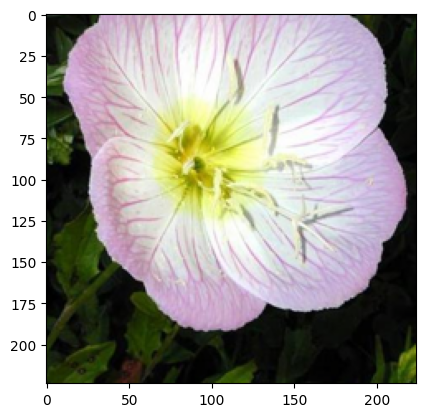

In [ ]:
image_path = '/content/flowers/test/1/image_06743.jpg'  # Replace with your image path
processed_image = process_image(image_path)
imshow(processed_image)
plt.show()

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
import torch.nn.functional as F

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    Args:
        image_path (str): Path to the image file.
        model (torch.nn.Module): Trained PyTorch model.
        topk (int): Number of top predictions to return.

    Returns:
        tuple: Probabilities and corresponding class labels.
    '''
    # Process the image
    image = process_image(image_path)
    image = image.unsqueeze(0)  # Add batch dimension

    # Move to appropriate device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image = image.to(device)

    # Set model to evaluation mode
    model.eval()

    # Make prediction
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)

    # Get top-k probabilities and indices
    top_probs, top_indices = probabilities.topk(topk, dim=1)

    # Detach and convert to lists
    top_probs = top_probs.cpu().numpy().flatten()
    top_indices = top_indices.cpu().numpy().flatten()

    # Map indices to class labels
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    top_classes = [idx_to_class[idx] for idx in top_indices]

    return top_probs, top_classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

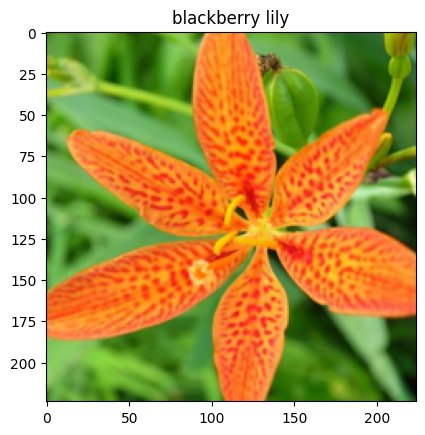

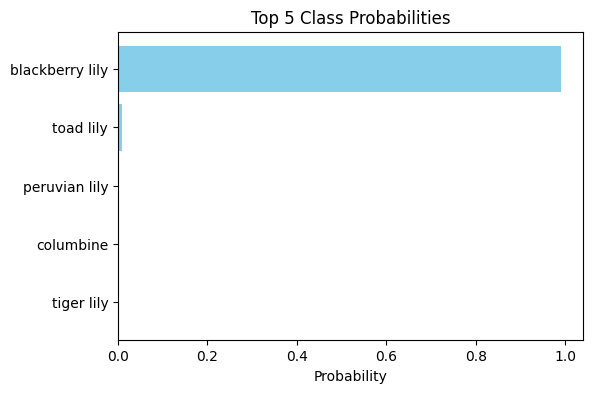

In [ ]:
# TODO: Display an image along with the top 5 classes
def sanity_check(image_path, model, topk=5):
    ''' Display image and top-K class probabilities as a bar chart.
    Args:
        image_path (str): Path to the image.
        model (torch.nn.Module): Trained PyTorch model.
        topk (int): Number of top predictions to display.
    '''
    # Get the top-K predictions and class labels
    probs, classes = predict(image_path, model, topk)

    # Get flower names from class indices
    flower_names = [cat_to_name[str(cls)] for cls in classes]

    # Display the image
    image = process_image(image_path)
    imshow(image)
    plt.title(flower_names[0])  # Title with the top prediction

    # Create a bar chart for the probabilities
    plt.figure(figsize=(6, 4))
    plt.barh(flower_names, probs, color='skyblue')
    plt.xlabel('Probability')
    plt.title('Top 5 Class Probabilities')
    plt.gca().invert_yaxis()  # Invert y-axis for better visualization (highest at top)
    plt.show()

# Example usage
image_path = '/content/flowers/test/102/image_08004.jpg'  # Replace with your image path
sanity_check(image_path, model, topk=5)


In [11]:
!python "/content/drive/MyDrive/Udacity/train.py" '/content/flowers' --arch "vgg16" --epochs 5 --learning_rate 0.001 --save_dir "./" --gpu

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5.. Train loss: 2.519.. Validation loss: 0.850.. Validation accuracy: 0.778
Epoch 2/5.. Train loss: 1.290.. Validation loss: 0.584.. Validation accuracy: 0.842
Epoch 3/5.. Train loss: 1.070.. Validation loss: 0.523.. Validation accuracy: 0.843
Epoch 4/5.. Train loss: 0.982.. Validation loss: 0.500.. Validation accuracy: 0.869
Epoch 5/5.. Train loss: 0.944.. Validation loss

In [12]:
!python "/content/drive/MyDrive/Udacity/predict.py" '/content/flowers/test/102/image_08004.jpg' /content/checkpoint.pth --top_k 3 --category_names "/content/drive/MyDrive/Udacity/cat_to_name.json" --gpu

/content/drive/MyDrive/Udacity/predict.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location='cpu')
/usr/local/lib/python3.11/d